---------------

**If any part of this notebook is used in your research, please cite with the reference found in** **[README.md](https://github.com/pysal/spaghetti#bibtex-citation).**

----------------

## The Transportation Problem
### Integrating `pysal/spaghetti` and [python-mip](https://github.com/coin-or/python-mip) for optimal shipping

**Author: James D. Gaboardi** **<jgaboardi@gmail.com>**

**This notebook provides a use case for:**

1. Introducing the Transportation Problem
2. Declaration of a solution class and model parameters
3. Solving the Transportation Problem for an optimal shipment plan

In [1]:
%load_ext watermark
%watermark

2020-02-18T20:54:04-05:00

CPython 3.7.3
IPython 7.10.2

compiler   : Clang 9.0.0 (tags/RELEASE_900/final)
system     : Darwin
release    : 19.3.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import geopandas
from libpysal import examples
import matplotlib
import mip
import numpy
import os
import spaghetti
import matplotlib_scalebar
from matplotlib_scalebar.scalebar import ScaleBar

%matplotlib inline
%watermark -w
%watermark -iv

Using Python-MIP package version 1.6.8
watermark 2.0.2
matplotlib_scalebar 0.6.1
geopandas           0.6.2
spaghetti           1.4.1
matplotlib          3.1.2
numpy               1.17.3
mip                 1.6.8



In [3]:
try:
    from IPython.display import set_matplotlib_formats
    set_matplotlib_formats("retina")
except ImportError:
    pass

-----------------------------

### 1 Introduction
#### Scenario

There are **8** schools in Neighborhood Y of City X and a total of **100** microscopes for the biology classes at the **8** schools, though the microscopes are not evenly distributed across the locations. Since last academic year there has been a significant enrollment shift in the neighborhood, and at **4** of the schools there is a surplus whereas the remaining **4** schools require additional microscopes. Dr. Rachel Carson, the head of the biology department at City X's School Board decides to utilize a mathematical programming model to solve the microscope discrepency. After consideration, she selects the Transportation Problem.


The Transportation Problem seeks to allocate supply to demand while minimizing transportation costs and was formally described by Hitchcock (1941). Supply ($\textit{n}$) and demand ($\textit{m}$) are generally represented as unit weights of decision variables at facilities along a network with the time or distance between nodes representing the cost of transporting one unit from a supply node to a demand node. These costs are stored in an $\textit{n x m}$ cost matrix.

--------------------------------

#### Integer Linear Programming Formulation based on Daskin (2013, Ch. 2).

$\begin{array}
\displaystyle \normalsize \textrm{Minimize} & \displaystyle \normalsize \sum_{i \in I} \sum_{j \in J} c_{ij}x_{ij}  & & & &  \normalsize (1) \\
\normalsize \textrm{Subject To} & \displaystyle \normalsize \sum_{j \in J} x_{ij} \leq S_i & \normalsize \forall i \in I; &  & &\normalsize (2)\\
 & \displaystyle \normalsize \sum_{i \in I} x_{ij} \geq D_j & \normalsize \forall j \in J; &  & &\normalsize (3)\\
& \displaystyle \normalsize x_{ij} \geq 0 & \displaystyle \normalsize \forall i \in I & \displaystyle \normalsize \normalsize \forall j \in j. & &\normalsize (4)\\
\end{array}$

$\begin{array}
\displaystyle \normalsize \textrm{Where} & \small i & \small = & \small \textrm{each potential origin node} &&&&\\
& \small I & \small = & \small \textrm{the complete set of potential origin nodes} &&&&\\
& \small j & \small = & \small \textrm{each potential destination node} &&&&\\
& \small J & \small = & \small \textrm{the complete set of potential destination nodes} &&&&\\
& \small x_{ij} & \small = & \small \textrm{amount to be shipped from } i \in I \textrm{ to } j \in J  &&&&\\
& \small c_{ij} & \small = & \small \textrm{per unit shipping costs between all } i,j \textrm{ pairs} &&&& \\
& \small S_i & \small = & \small \textrm{node } i \textrm{ supply for } i \in I &&&&\\
& \small D_j & \small = & \small \textrm{node } j \textrm{ demand for } j \in J &&&&\\
\end{array}$


---------------------------------

**References**

* **Church, Richard L. and Murray, Alan T.** (2009) *Business Site Selection, Locational Analysis, and GIS*. Hoboken. John Wiley & Sons, Inc.

* **Daskin, M.** (2013) *Network and Discrete Location: Models, Algorithms, and Applications*. New York: John Wiley & Sons, Inc.

* **Gass, S. I. and Assad, A. A.** (2005) *An Annotated Timeline of Operations Research: An Informal History*. Springer US.

* **Hitchcock, Frank L.** (1941) *The Distribution of a Product from Several Sources to Numerous Localities*. Journal of Mathematics and Physics. 20(1):224-230.

* **Koopmans, Tjalling C.** (1949) *Optimum Utilization of the Transportation System*. Econometrica. 17:136-146.

* **Miller, H. J. and Shaw, S.-L.** (2001) *Geographic Information Systems for Transportation: Principles and Applications*. New York. Oxford University Press.


* **Phillips, Don T. and Garcia‐Diaz, Alberto.** (1981) *Fundamentals of Network Analysis*. Englewood Cliffs. Prentice Hall. 

-------------------------------------

### 2. A model, data, and parameters
#### Schools labeled as either 'supply' or 'demand' locations

In [4]:
supply_schools = [1, 6, 7, 8]
demand_schools = [2, 3, 4, 5]

#### Amount of supply and demand at each location (indexed by ``supply_schools`` and ``demand_schools``)

In [5]:
amount_supply = [20, 30, 15, 35]
amount_demand = [5, 45, 10, 40]

#### Solution class

In [6]:
class TransportationProblem:
    def __init__(
        self,
        supply_nodes,
        demand_nodes,
        cij,
        si,
        dj,
        xij_tag="x_%s,%s",
        supply_constr_tag="supply(%s)",
        demand_constr_tag="demand(%s)",
        solver="cbc",
        display=True,
    ):
        """Instantiate and solve the Primal Transportation Problem
        based the formulation from Daskin (2013, Ch. 2).
        
        Parameters
        ----------
        supply_nodes : geopandas.GeoSeries
            Supply node decision variables.
        demand_nodes : geopandas.GeoSeries
            Demand node decision variables.
        cij : numpy.array
            Supply-to-demand distance matrix for nodes.
        si : geopandas.GeoSeries
            Amount that can be supplied by each supply node.
        dj : geopandas.GeoSeries
            Amount that can be received by each demand node.
        xij_tag : str
            Shipping decision variable names within the model. Default is
            'x_%s,%s' where %s indicates string formatting.
        supply_constr_tag : str
            Supply constraint labels. Default is 'supply(%s)'.
        demand_constr_tag : str
            Demand constraint labels. Default is 'demand(%s)'.
        solver : str
            Default is 'cbc' (coin-branch-cut). Can be set
            to 'gurobi' (if Gurobi is installed).
        display : bool
            Print out solution results.
        
        Attributes
        ----------
        supply_nodes : See description in above.  
        demand_nodes : See description in above.
        cij : See description in above.
        si : See description in above.
        dj : See description in above.
        xij_tag : See description in above.
        supply_constr_tag : See description in above.
        demand_constr_tag : See description in above.
        rows : int
            The number of supply nodes.
        rrows : range
            The index of supply nodes.
        cols : int
            The number of demand nodes.
        rcols : range
            The index of demand nodes.
        model : mip.model.Model
            Integer Linear Programming problem instance.
        xij : numpy.array
            Shipping decision variables (``mip.entities.Var``).
        """

        # all nodes to be visited
        self.supply_nodes, self.demand_nodes = supply_nodes, demand_nodes
        # shipping costs (distance matrix) and amounts
        self.cij, self.si, self.dj = cij, si.values, dj.values
        self.ensure_float()
        # alpha tag for decision variables
        self.xij_tag = xij_tag
        # alpha tag for supply and demand constraints
        self.supply_constr_tag = supply_constr_tag
        self.demand_constr_tag = demand_constr_tag
        
        # instantiate a model
        self.model = mip.Model(" TransportationProblem", solver_name=solver)
        # define row and column indices
        self.rows, self.cols = self.si.shape[0], self.dj.shape[0]
        self.rrows, self.rcols = range(self.rows), range(self.cols)
        # create and set the decision variables
        self.shipping_dvs()
        # set the objective function
        self.objective_func()
        # add supply constraints
        self.add_supply_constrs()
        # add demand constraints
        self.add_demand_constrs()
        # solve
        self.solve(display=display)
        # shipping decisions lookup
        self.get_decisions(display=display)

    def ensure_float(self):
        """Convert integers to floats (rough edge in mip.LinExpr)"""
        self.cij = self.cij.astype(float)
        self.si = self.si.astype(float)
        self.dj = self.dj.astype(float)

    def shipping_dvs(self):
        """Create the shipping decision variables - eq (4)."""

        def _s(_x):
            """Helper for naming variables"""
            return self.supply_nodes[_x].split("_")[-1]

        def _d(_x):
            """Helper for naming variables"""
            return self.demand_nodes[_x].split("_")[-1]

        xij = numpy.array(
            [
                [self.model.add_var(self.xij_tag % (_s(i), _d(j))) for j in self.rcols]
                for i in self.rrows
            ]
        )
        self.xij = xij

    def objective_func(self):
        """Add the objective function - eq (1)."""
        self.model.objective = mip.minimize(
            mip.xsum(
                self.cij[i, j] * self.xij[i, j] for i in self.rrows for j in self.rcols
            )
        )

    def add_supply_constrs(self):
        """Add supply contraints to the model - eq (2)."""
        for i in self.rrows:
            rhs, label = self.si[i], self.supply_constr_tag % i
            self.model += mip.xsum(self.xij[i, j] for j in self.rcols) <= rhs, label

    def add_demand_constrs(self):
        """Add demand contraints to the model - eq (3)."""
        for j in self.rcols:
            rhs, label = self.dj[j], self.demand_constr_tag % j
            self.model += mip.xsum(self.xij[i, j] for i in self.rrows) >= rhs, label

    def solve(self, display=True):
        """Solve the model"""
        self.model.optimize()
        if display:
            obj = round(self.model.objective_value, 4)
            print("Minimized shipping costs: %s" % obj)

    def get_decisions(self, display=True):
        """Fetch the selected decision variables."""
        shipping_decisions = {}
        if display:
            print("\nShipping decisions:")
        for i in self.rrows:
            for j in self.rcols:
                v, vx = self.xij[i, j], self.xij[i, j].x
                if vx > 0:
                    if display:
                        print("\t", v, vx)
                    shipping_decisions[v.name] = vx
        self.shipping_decisions = shipping_decisions

    def print_lp(self, name=None):
        """Save LP file in order to read in and print."""
        if not name:
            name = self.model.name
        lp_file_name = "%s.lp" % name
        self.model.write(lp_file_name)
        lp_file = open(lp_file_name, "r")
        lp = lp_file.read()
        print("\n", lp)
        lp_file.close()
        os.remove(lp_file_name)

    def extract_shipments(self, paths, id_col, ship="ship"):
        """Extract the supply to demand shipments as a 
        ``geopandas.GeoDataFrame`` of ``shapely.geometry.LineString`` objects.
        
        Parameters
        ----------
        paths : geopandas.GeoDataFrame
            Shortest-path routes between all ``self.supply_nodes``
            and ``self.demand_nodes``.
        id_col : str
            ID column name.
        ship : str
            Column name for the amount of good shipped.
            Default is 'ship'.
        
        Returns
        -------
        shipments : geopandas.GeoDataFrame
            Optimal shipments from ``self.supply_nodes`` to
            ``self.demand_nodes``.
        """

        def _id(sp):
            """ID label helper"""
            return tuple([int(i) for i in sp.split("_")[-1].split(",")])

        paths[ship] = int
        # set label of the shipping path for each OD pair.
        for ship_path, shipment in self.shipping_decisions.items():
            paths.loc[(paths[id_col] == _id(ship_path)), ship] = shipment
        # extract only shiiping paths
        shipments = paths[paths[ship] != int].copy()
        shipments[ship] = shipments[ship].astype(int)

        return shipments

#### Plotting helper functions and constants
**Note: originating shipments**

In [7]:
shipping_colors = ["maroon", "cyan", "magenta", "orange"]

In [8]:
def obs_labels(o, b, s, col="id", **kwargs):
    """Label each point pattern observation."""

    def _lab_loc(_x):
        """Helper for labeling observations."""
        return _x.geometry.coords[0]

    if o.index.name != "schools":
        X = o.index.name[0]
    else:
        X = ""
    kws = {"size": s, "ha": "left", "va": "bottom", "style": "oblique"}
    kws.update(kwargs)
    o.apply(lambda x: b.annotate(s=X + str(x[col]), xy=_lab_loc(x), **kws), axis=1)

In [9]:
def make_patches(objects):
    """Create patches for legend"""
    patches = []
    for _object in objects:
        try:
            oname = _object.index.name
        except AttributeError:
            oname = "shipping"
        if oname.split(" ")[0] in ["schools", "supply", "demand"]:
            ovalue = _object.shape[0]
            if oname == "schools":
                ms, m, c, a = 3, "o", "k", 1
            elif oname.startswith("supply"):
                ms, m, c, a = 10, "o", "b", 0.25
            elif oname.startswith("demand"):
                ms, m, c, a = 10, "o", "g", 0.25
            if oname.endswith("snapped"):
                ms, m, a = float(ms) / 2.0, "x", 1
            _kws = {"lw": 0, "c": c, "marker": m, "ms": ms, "alpha": a}
            label = "%s — %s" % (oname.capitalize(), int(ovalue))
            p = matplotlib.lines.Line2D([], [], label=label, **_kws)
            patches.append(p)
        else:
            patch_info = plot_shipments(_object, "", for_legend=True)
            for c, lw, lwsc, (i, j) in patch_info:
                label = "s%s$\\rightarrow$d%s — %s microscopes" % (i, j, lw)
                _kws = {"alpha": 0.75, "c": c, "lw": lwsc, "label": label}
                p = matplotlib.lines.Line2D([], [], solid_capstyle="round", **_kws)
                patches.append(p)
    return patches

In [10]:
def legend(objects, anchor=(1.005, 1.016)):
    """Add a legend to a plot"""
    patches = make_patches(objects)
    kws = {"fancybox": True, "framealpha": 0.85, "fontsize": "x-large"}
    kws.update({"bbox_to_anchor":anchor, "labelspacing":2., "borderpad":2.})
    legend = matplotlib.pyplot.legend(handles=patches, **kws)
    legend.get_frame().set_facecolor("white")

In [11]:
def plot_shipments(sd, b, scaled=0.75, for_legend=False):
    """Helper for plotting shipments based on OD and magnitude"""
    _patches = []
    _plot_kws = {"alpha":0.75, "zorder":0, "capstyle":"round"}
    for c, (g, gdf) in zip(shipping_colors, sd):
        lw, lw_scaled, ids = gdf["ship"], gdf["ship"] * scaled, gdf["id"]
        if for_legend:
            for _lw, _lwsc, _id in zip(lw, lw_scaled, ids):
                _patches.append([c, _lw, _lwsc, _id])
        else:
            gdf.plot(ax=b, color=c, lw=lw_scaled, **_plot_kws)
    if for_legend:
        return _patches

--------------------------------------------------------
#### Streets

In [12]:
streets = geopandas.read_file(examples.get_path("streets.shp"))
streets.crs = "epsg:2223"
streets = streets.to_crs("epsg:2762")

#### Schools

In [13]:
schools = geopandas.read_file(examples.get_path("schools.shp"))
schools.index.name = "schools"
schools.crs = "epsg:2223"
schools = schools.to_crs("epsg:2762")

#### Schools - supply nodes

In [14]:
schools_supply = schools[schools["POLYID"].isin(supply_schools)]
schools_supply.index.name = "supply"
schools_supply

,POLYID,geometry
supply,,
0,1,POINT (221614.608 268182.322)
5,6,POINT (221542.156 268184.287)
6,7,POINT (221847.332 267982.491)
7,8,POINT (221406.289 267990.060)


#### Schools - demand nodes

In [15]:
schools_demand = schools[schools["POLYID"].isin(demand_schools)]
schools_demand.index.name = "demand"
schools_demand

,POLYID,geometry
demand,,
1,2,POINT (221121.722 268130.726)
2,3,POINT (221474.120 267187.725)
3,4,POINT (220452.594 268086.776)
4,5,POINT (221235.286 267684.289)


#### Instantiate a network object

In [16]:
ntw = spaghetti.Network(in_data=streets)
vertices, arcs = spaghetti.element_as_gdf(ntw, vertices=True, arcs=True)

#### Plot

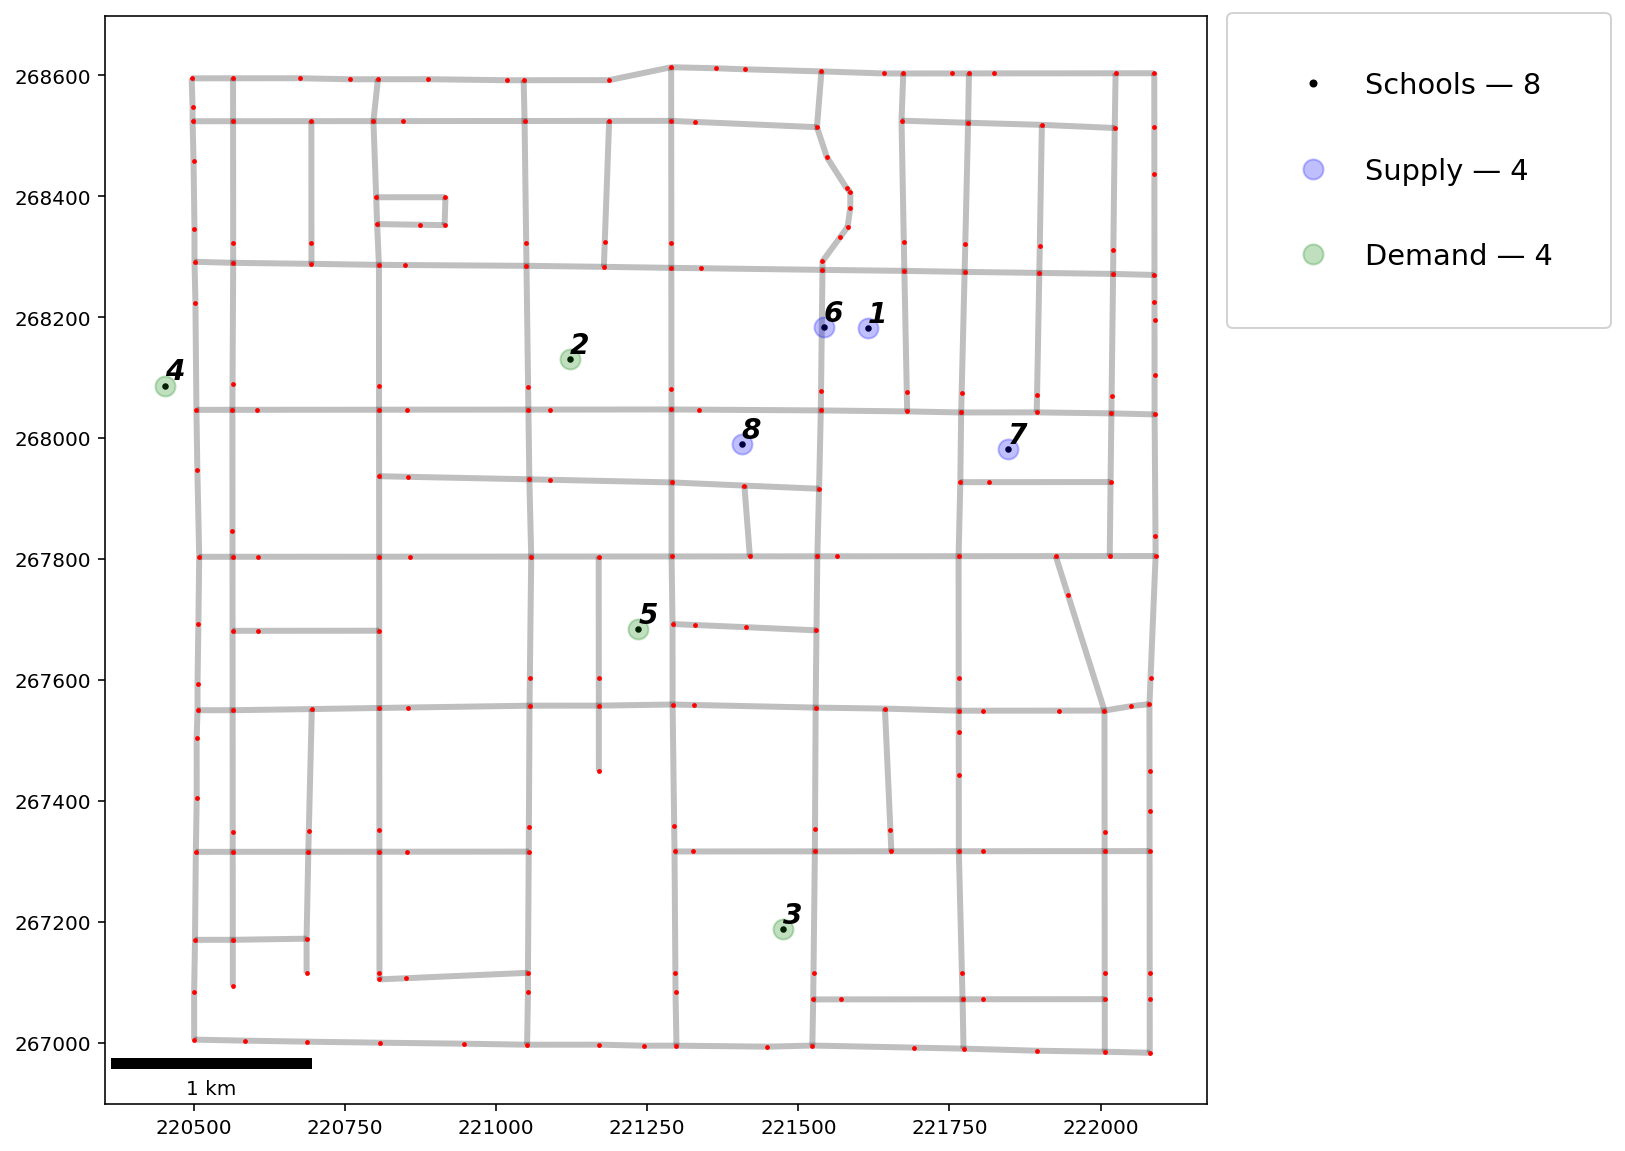

In [17]:
# plot network
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=2, color="red", zorder=1)
# plot observations
schools.plot(ax=base, markersize=5, color="k", zorder=2)
schools_supply.plot(ax=base, markersize=100, alpha=0.25, color="b", zorder=2)
schools_demand.plot(ax=base, markersize=100, alpha=0.25, color="g", zorder=2)
# add labels
obs_labels(schools, base, 14, col="POLYID", c="k", weight="bold")
# add legend
elements = [schools, schools_supply, schools_demand]
legend(elements)
# add scale bar
scalebar = ScaleBar(3, units="m", location="lower left")
base.add_artist(scalebar);

#### Associate both the supply and demand schools with the network and plot

In [18]:
ntw.snapobservations(schools_supply, "supply")
supply = spaghetti.element_as_gdf(ntw, pp_name="supply")
supply.index.name = "supply"
supply_snapped = spaghetti.element_as_gdf(ntw, pp_name="supply", snapped=True)
supply_snapped.index.name = "supply snapped"
supply_snapped

,id,geometry
supply snapped,,
0,0,POINT (221677.280 268183.579)
1,1,POINT (221538.890 268184.326)
2,2,POINT (221847.381 267926.950)
3,3,POINT (221406.647 268046.397)


In [19]:
ntw.snapobservations(schools_demand, "demand")
demand = spaghetti.element_as_gdf(ntw, pp_name="demand")
demand.index.name = "demand"
demand_snapped = spaghetti.element_as_gdf(ntw, pp_name="demand", snapped=True)
demand_snapped.index.name = "demand snapped"
demand_snapped

,id,geometry
demand snapped,,
0,0,POINT (221052.520 268129.805)
1,1,POINT (221525.970 267187.138)
2,2,POINT (220504.172 268087.247)
3,3,POINT (221292.004 267684.336)


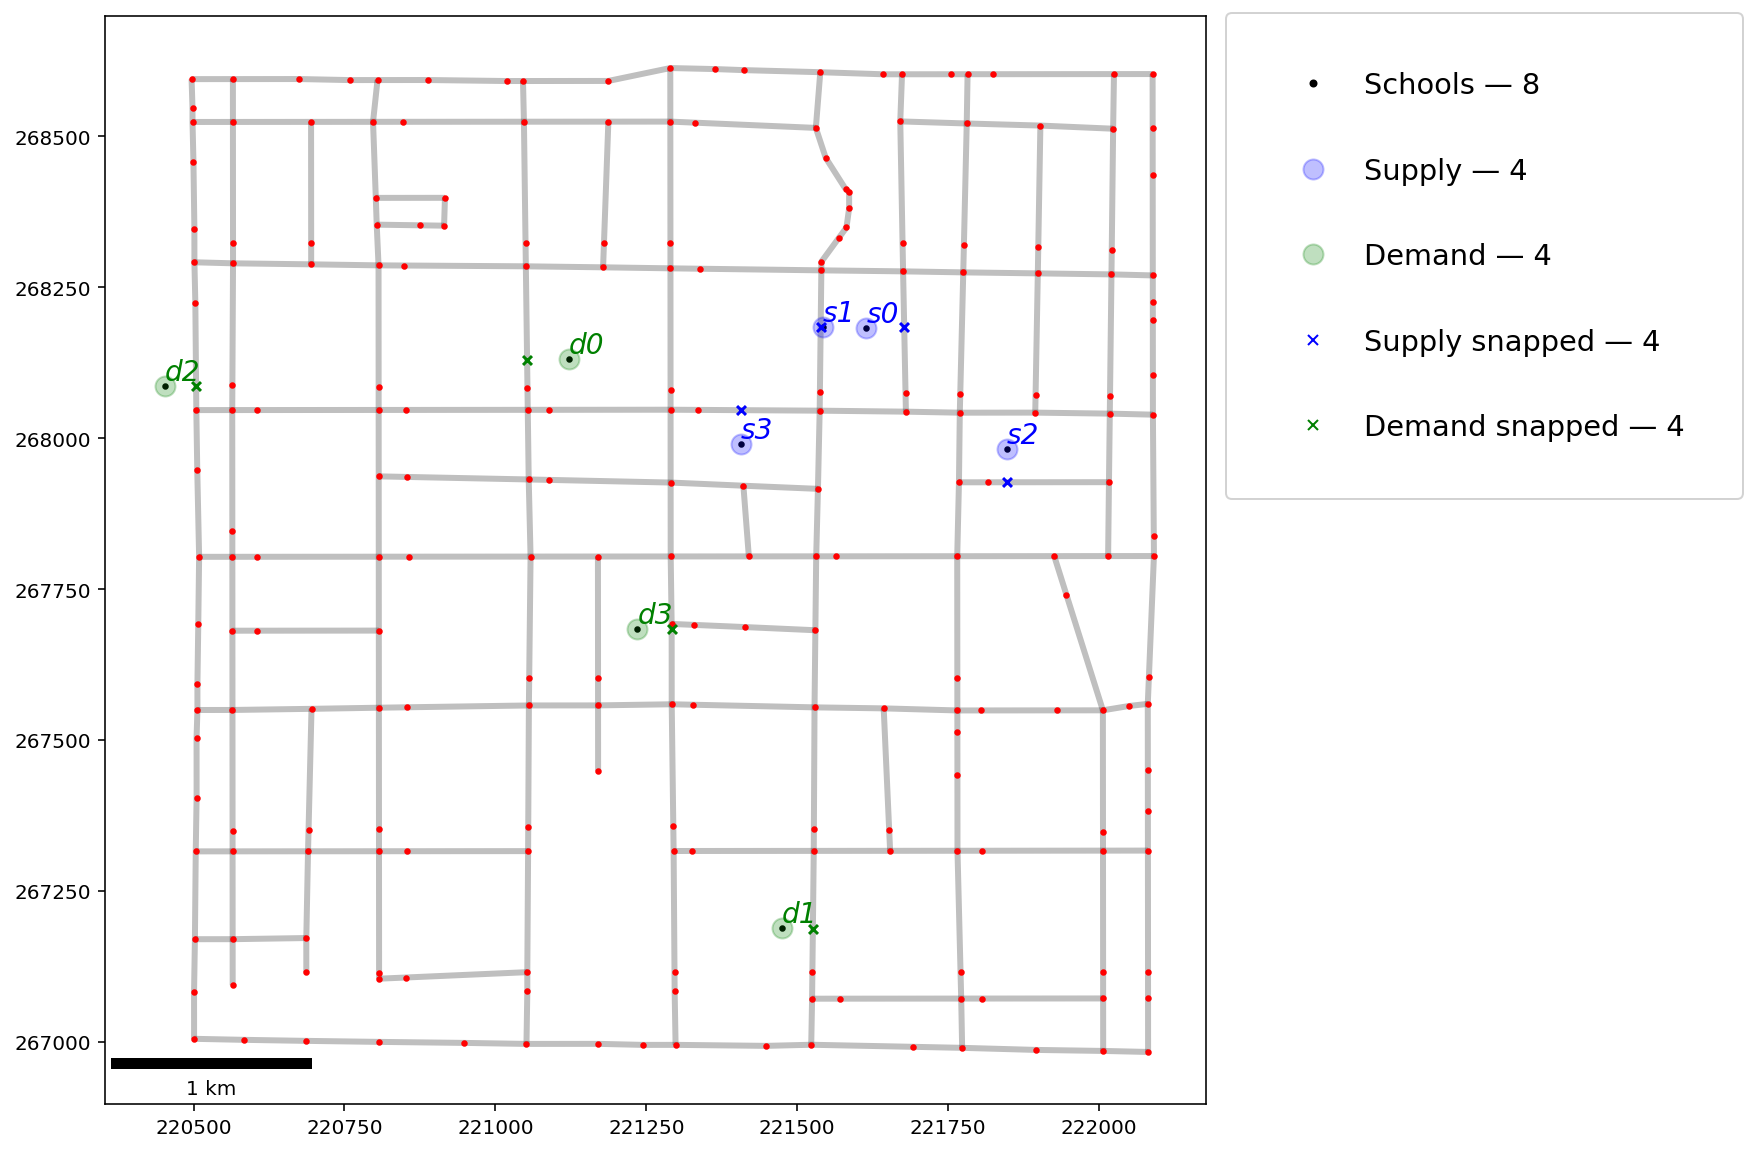

In [20]:
# plot network
base = arcs.plot(linewidth=3, alpha=0.25, color="k", zorder=0, figsize=(10, 10))
vertices.plot(ax=base, markersize=5, color="r", zorder=1)
# plot observations
schools.plot(ax=base, markersize=5, color="k", zorder=2)
supply.plot(ax=base, markersize=100, alpha=0.25, color="b", zorder=3)
supply_snapped.plot(ax=base, markersize=20, marker="x", color="b", zorder=3)
demand.plot(ax=base, markersize=100, alpha=0.25, color="g", zorder=2)
demand_snapped.plot(ax=base, markersize=20, marker="x", color="g", zorder=3)
# add labels
obs_labels(supply, base, 14, c="b")
obs_labels(demand, base, 14, c="g")
# add legend
elements += [supply_snapped, demand_snapped]
legend(elements)
# add scale bar
scalebar = ScaleBar(3, units="m", location="lower left")
base.add_artist(scalebar);

#### Calculate distance matrix while generating shortest path trees

In [21]:
s2d, tree = ntw.allneighbordistances("supply", "demand", gen_tree=True)
s2d[:3, :3]

array([[ 849.03214874, 1141.07882307, 1355.96894348],
       [ 705.24686884,  997.29354317, 1212.18366358],
       [ 993.3892737 , 1052.63164495, 1500.32606844]])

In [22]:
list(tree.items())[:4], list(tree.items())[-4:]

([((0, 0), (216, 218)),
  ((0, 1), (216, 130)),
  ((0, 2), (216, 24)),
  ((0, 3), (216, 55))],
 [((3, 0), (65, 218)),
  ((3, 1), (64, 130)),
  ((3, 2), (65, 24)),
  ((3, 3), (65, 55))])

--------------------------------
### 3. The Transportation Problem
#### Create decision variables for the supply locations and amount to be supplied

In [23]:
supply["dv"] = supply["id"].apply(lambda _id: "s_%s" % _id)
supply["s_i"] = amount_supply
supply

,id,geometry,dv,s_i
supply,,,,
0,0,POINT (221614.608 268182.322),s_0,20
1,1,POINT (221542.156 268184.287),s_1,30
2,2,POINT (221847.332 267982.491),s_2,15
3,3,POINT (221406.289 267990.060),s_3,35


#### Create decision variables for the demand locations and amount to be received

In [24]:
demand["dv"] = demand["id"].apply(lambda _id: "d_%s" % _id)
demand["d_j"] = amount_demand
demand

,id,geometry,dv,d_j
demand,,,,
0,0,POINT (221121.722 268130.726),d_0,5
1,1,POINT (221474.120 267187.725),d_1,45
2,2,POINT (220452.594 268086.776),d_2,10
3,3,POINT (221235.286 267684.289),d_3,40


#### Solve the Transportation Problem
**Note: shipping costs are in meters per microscope**

In [25]:
s, d, s_i, d_j = supply["dv"], demand["dv"], supply["s_i"], demand["d_j"]
trans_prob = TransportationProblem(s, d, s2d, s_i, d_j)

Minimized shipping costs: 84595.5083

Shipping decisions:
	 x_0,3 20.0
	 x_1,1 30.0
	 x_2,1 15.0
	 x_3,0 5.0
	 x_3,2 10.0
	 x_3,3 20.0


#### Linear program  (compare to its formulation in the Introduction)

In [26]:
trans_prob.print_lp()


 \Problem name:  TransportationProblem

Minimize
OBJROW: 849.03215 x_0,0 + 1141.07882 x_0,1 + 1355.96894 x_0,2 + 884.73001 x_0,3 + 705.24687 x_1,0 + 997.29354 x_1,1 + 1212.18366 x_1,2 + 740.94473 x_1,3 + 993.38927 x_2,0 + 1052.63164 x_2,1
 + 1500.32607 x_2,2 + 796.28284 x_2,3 + 435.89260 x_3,0 + 989.11235 x_3,1 + 942.82940 x_3,2 + 479.24350 x_3,3
Subject To
supply(0):  x_0,0 + x_0,1 + x_0,2 + x_0,3 <= 20
supply(1):  x_1,0 + x_1,1 + x_1,2 + x_1,3 <= 30
supply(2):  x_2,0 + x_2,1 + x_2,2 + x_2,3 <= 15
supply(3):  x_3,0 + x_3,1 + x_3,2 + x_3,3 <= 35
demand(0):  x_0,0 + x_1,0 + x_2,0 + x_3,0 >= 5
demand(1):  x_0,1 + x_1,1 + x_2,1 + x_3,1 >= 45
demand(2):  x_0,2 + x_1,2 + x_2,2 + x_3,2 >= 10
demand(3):  x_0,3 + x_1,3 + x_2,3 + x_3,3 >= 40
Bounds
End



####  Extract all network shortest paths

In [27]:
paths = ntw.shortest_paths(tree, "supply", "demand")
paths_gdf = spaghetti.element_as_gdf(ntw, routes=paths)
paths_gdf.head()

,geometry,O,D,id
0,"LINESTRING (221677.280 268183.579, 221679.454 ...",0,0,"(0, 0)"
1,"LINESTRING (221677.280 268183.579, 221679.454 ...",0,1,"(0, 1)"
2,"LINESTRING (221677.280 268183.579, 221679.454 ...",0,2,"(0, 2)"
3,"LINESTRING (221677.280 268183.579, 221679.454 ...",0,3,"(0, 3)"
4,"LINESTRING (221538.890 268184.326, 221537.605 ...",1,0,"(1, 0)"


####  Extract the shipping paths

In [28]:
shipments = trans_prob.extract_shipments(paths_gdf, "id")
shipments

,geometry,O,D,id,ship
3,"LINESTRING (221677.280 268183.579, 221679.454 ...",0,3,"(0, 3)",20
5,"LINESTRING (221538.890 268184.326, 221537.605 ...",1,1,"(1, 1)",30
9,"LINESTRING (221847.381 267926.950, 221815.312 ...",2,1,"(2, 1)",15
12,"LINESTRING (221406.647 268046.397, 221336.067 ...",3,0,"(3, 0)",5
14,"LINESTRING (221406.647 268046.397, 221336.067 ...",3,2,"(3, 2)",10
15,"LINESTRING (221406.647 268046.397, 221336.067 ...",3,3,"(3, 3)",20


#### Plot optimal shipping schedule

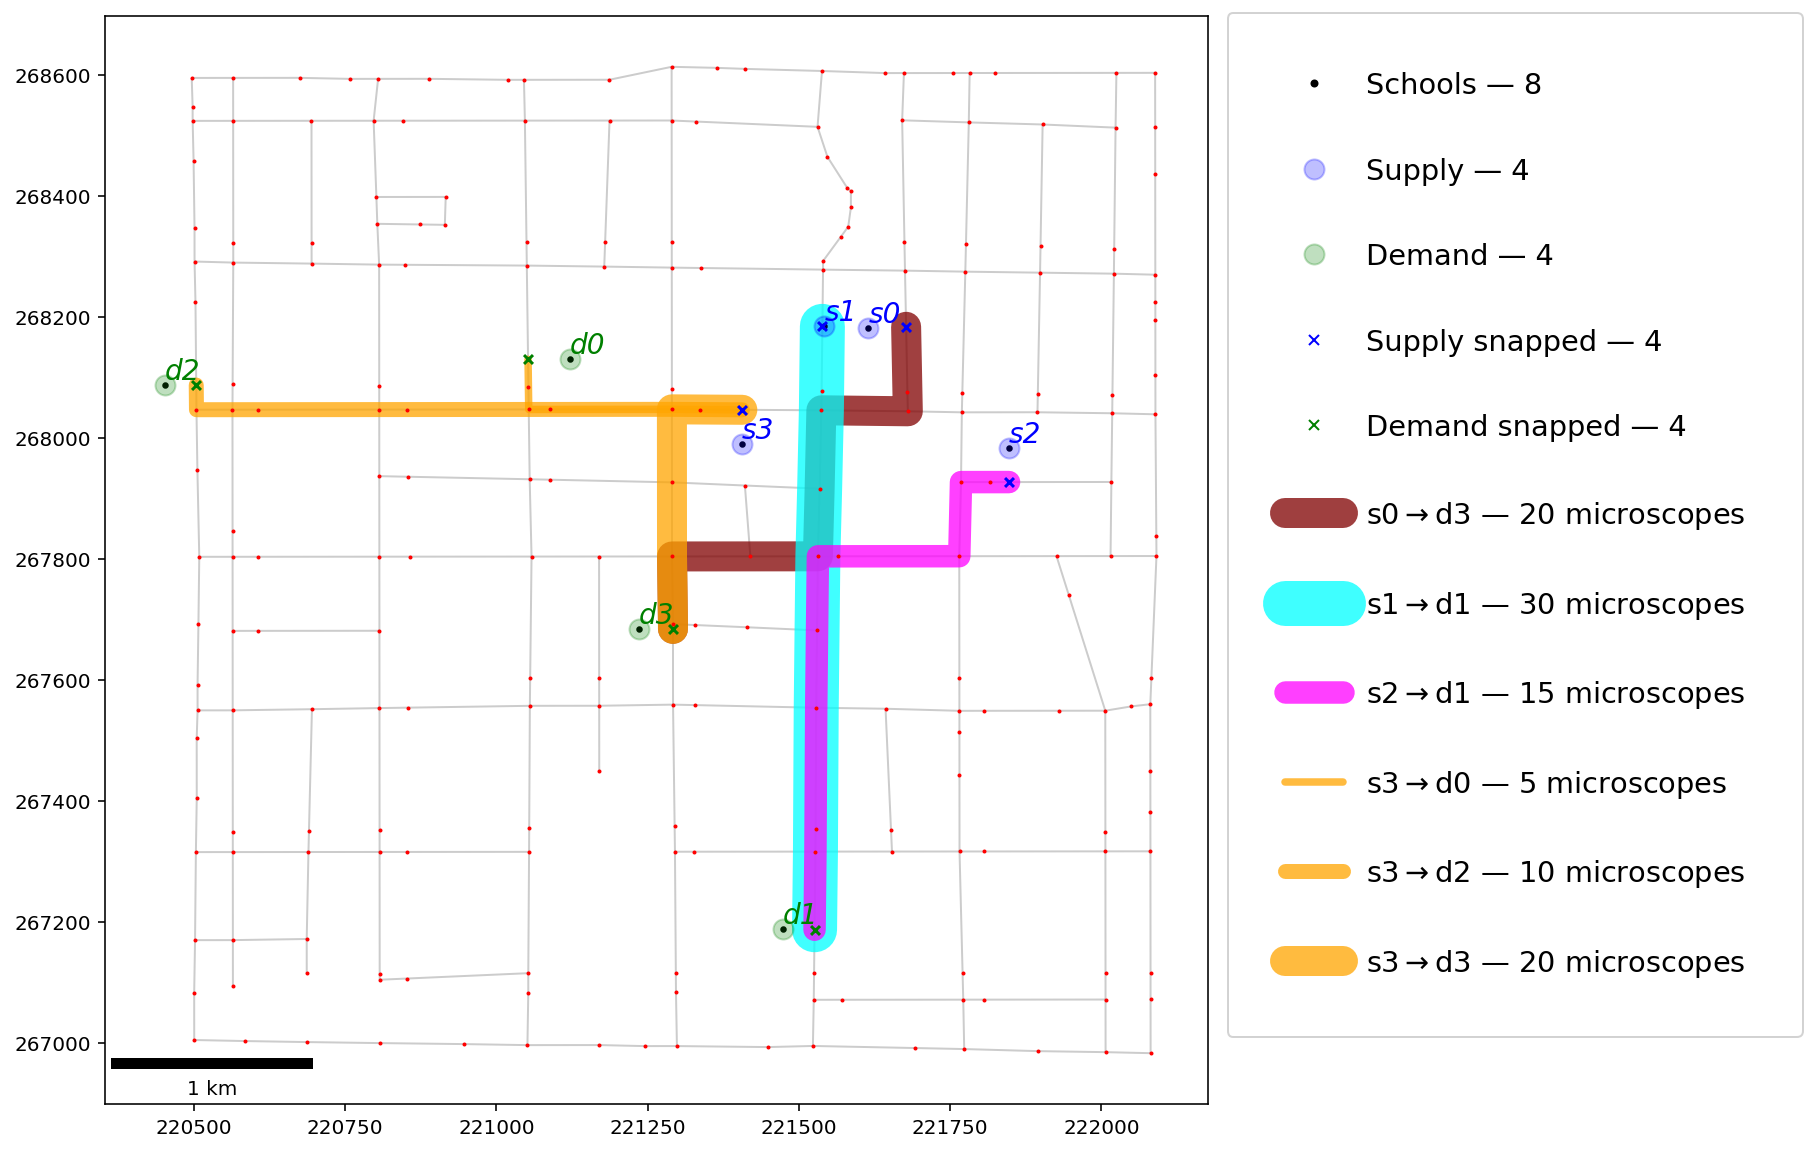

In [29]:
# plot network
base = arcs.plot(alpha=0.2, linewidth=1, color="k", figsize=(10, 10), zorder=0)
vertices.plot(ax=base, markersize=1, color="r", zorder=2)
# plot observations
schools.plot(ax=base, markersize=5, color="k", zorder=2)
supply.plot(ax=base, markersize=100, alpha=0.25, color="b", zorder=3)
supply_snapped.plot(ax=base, markersize=20, marker="x", color="b", zorder=3)
demand.plot(ax=base, markersize=100, alpha=0.25, color="g", zorder=2)
demand_snapped.plot(ax=base, markersize=20, marker="x", color="g", zorder=3)
# plot shipments
plot_shipments(shipments.groupby("O"), base)
# add labels
obs_labels(supply, base, 14, c="b")
obs_labels(demand, base, 14, c="g")
# add legend
elements += [shipments.groupby("O")]
legend(elements)
# add scale bar
scalebar = ScaleBar(3, units="m", location="lower left")
base.add_artist(scalebar);

---------------------------------
#### By utilizing the Transportation Problem, Dr. Carson has been able to minimize shipping costs and redistribute the microscopes to the schools in need!

----------------------